# qinfer demo

In [1]:
import sys
sys.path.append("../../../")
import numpy as np
import matplotlib.pyplot as plt
import analysis.lib.sim.electron_nuclear_sim as nvs
from tqdm import tnrange, tqdm_notebook
plt.style.use('ggplot')

## A simple simulation

In [2]:
NV = nvs.NV_system()
NV.recalculate()
exp = nvs.NV_experiment(NV)

../../../analysis/lib/sim/electron_nuclear_sim.py:249: UserWarning: No carbon params passed, using dummy params!
  warnings.warn('No carbon params passed, using dummy params!')


In [7]:
mygate1 = nvs.gate(lambda : NV.e_op(nvs.spin_x_rotation(theta1)), 'mygate1')
mygate2 = nvs.gate(lambda : NV.e_op(nvs.spin_x_rotation(theta2)), 'mygate2')

In [8]:
g_seq = exp.gate_sequence()
g_seq.ye()
g_seq.add_gate_to_seq(mygate1)
g_seq.wait_gate(lambda : tau)
g_seq.ye()
g_seq.add_gate_to_seq(mygate2)

In [23]:
res = []
space = np.linspace(5e-6, 200e-6, 100)
theta1 = np.pi*1.2
theta2 = np.pi*1.6
for tau in space:
    exp.reset_init_state()
    exp.apply_gates(g_seq)
    res.extend([exp.measure_e()])

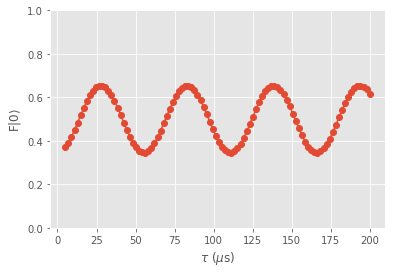

In [24]:
plt.plot(space*1e6, np.array(res), 'o-')
plt.ylim(0,1)
plt.xlabel(r'$\tau$ ($\mu$s)')
plt.ylabel(r'F|0$\rangle$');

## Import _qinfer_ and define our model 

In [17]:
import qinfer as qi

/opt/anaconda/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/opt/anaconda/lib/python3.6/site-packages/qinfer/parallel.py:52: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


In [18]:
class SuperEasyModel(qi.FiniteOutcomeModel):
    
    def __init__(self):
        super(SuperEasyModel, self).__init__(self)
        self.NV = nvs.NV_system()
        self.exp = nvs.NV_experiment(self.NV)
        
        mygate1 = nvs.gate(lambda : NV.e_op(nvs.spin_x_rotation(self.theta1)), 'mygate1')
        mygate2 = nvs.gate(lambda : NV.e_op(nvs.spin_x_rotation(self.theta2)), 'mygate2')
        
        self.g_seq = self.exp.gate_sequence()
        self.g_seq.ye()
        self.g_seq.add_gate_to_seq(mygate1)
        self.g_seq.wait_gate(lambda : self.tau)
        self.g_seq.ye()
        self.g_seq.add_gate_to_seq(mygate2)
    
    @property
    def n_modelparams(self):
        return 2
    
    @property
    def is_n_outcomes_constant(self):
        return True
    
    def n_outcomes(self, expparams):
        return 2
    
    def are_models_valid(self, modelparams):
        return np.all(np.logical_and(modelparams > -np.pi, modelparams < 3*np.pi), axis=1)
    
    @property
    def expparams_dtype(self):
        return [('tau', 'float', 1)]
    
    def likelihood(self, outcomes, modelparams, expparams):
        # We first call the superclass method, which basically
        # just makes sure that call count diagnostics are properly
        # logged.
        super(SuperEasyModel, self).likelihood(outcomes, modelparams, expparams)
        
        # Next, since we have a two-outcome model, everything is defined by
        # Pr(0 | modelparams; expparams), so we find the probability of 0
        # for each model and each experiment.
                
        pr0 = np.empty((len(modelparams), len(expparams)))
        for i, mp in enumerate(modelparams):
            self.theta1, self.theta2 = mp
            for j, self.tau in enumerate(expparams['tau']):
                self.exp.reset_init_state()
                self.exp.apply_gates(self.g_seq)
                pr0[i,j] = self.exp.measure_e()
        
        # Now we use pr0_to_likelihood_array to turn this two index array
        # above into the form expected by SMCUpdater and other consumers
        # of likelihood().
        return qi.FiniteOutcomeModel.pr0_to_likelihood_array(outcomes, pr0)

In [19]:
sem = SuperEasyModel()

../../../analysis/lib/sim/electron_nuclear_sim.py:249: UserWarning: No carbon params passed, using dummy params!
  warnings.warn('No carbon params passed, using dummy params!')


## Use model to simulate an experiment

In [20]:
modelp = np.array(((np.pi*1.2, np.pi*1.6), ))
expp = np.empty((100,), dtype = sem.expparams_dtype)
expp['tau'] = np.linspace(5e-6, 200e-6, 100)

In [27]:
measures = sem.simulate_experiment(modelp, expp, repeat=10000)

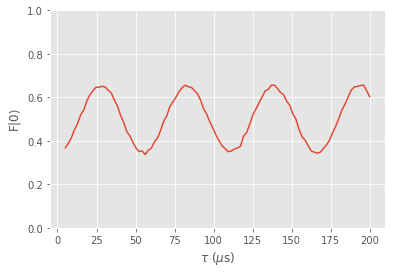

In [28]:
plt.plot(expp['tau']*1e6, 1 - measures.mean(axis=0)[0])
plt.ylim(0,1)
plt.xlabel(r'$\tau$ ($\mu$s)')
plt.ylabel(r'F|0$\rangle$');

## Define true values, and the updater

In [40]:
true_model = np.array(((np.pi*1.2, np.pi*1.6),))
prior = qi.ProductDistribution(
    qi.UniformDistribution([0, 2*np.pi]), 
    qi.UniformDistribution([1.4*np.pi, 1.8*np.pi]))
updater = qi.SMCUpdater(sem, 100, prior)

## Plot particles

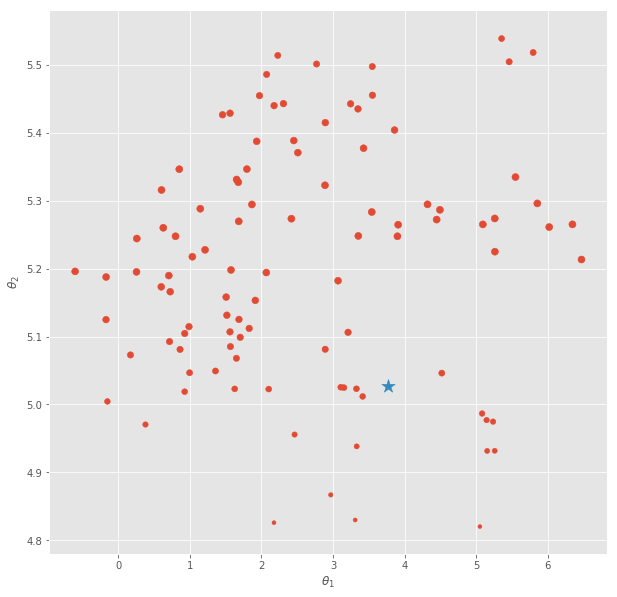

In [43]:
sizes = updater.particle_weights/updater.particle_weights.max() * 50
plt.figure(figsize=(10,10))
plt.scatter(updater.particle_locations[:,0], updater.particle_locations[:,1], s=sizes)
plt.scatter(true_model[0,0], true_model[0,1], marker='*', s=200)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.show()

## Simulate experiments and update model

In [42]:
for samples in tnrange(100):
    experiment = np.empty((1,), dtype = sem.expparams_dtype)
    experiment['tau'] = np.random.random() * 200e-6
    outcome = sem.simulate_experiment(true_model, experiment, repeat=500)
    updater.update(outcome, experiment)

## Marginal distributions

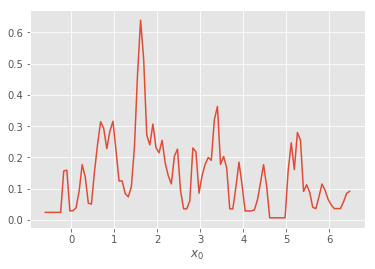

In [44]:
updater.plot_posterior_marginal(0)

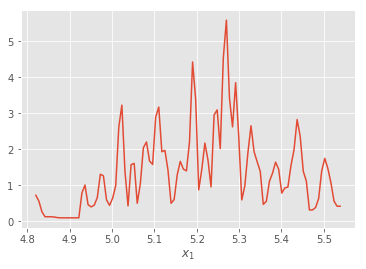

In [45]:
updater.plot_posterior_marginal(1)

[[ 3.76991118  5.02654825]]


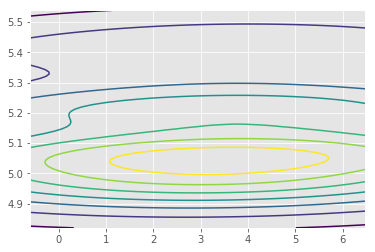

In [46]:
updater.plot_posterior_contour(smoothing=0.5)
print(true_model)